v3.

# Photometric Redshift Estimation

We will try to estimate the redshift from **DES** data using the match from the VVDS.

We use Machine Learning methods and Deep learning methods


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/zxcorr/zxcorr_DataAccess/main/DESzxcorr/pycode/astroFunctions.py -O astroFunctions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/PHOTOzxcorr/functions/") # user here the path where we download the folder DESzxcoorr
    
    

## Import Libraries

In [2]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.io import ascii 
from astropy.table import Table
import seaborn as sns
import time

# Regression Libraries
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# Other Libraries
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics


# Neural Network Libs
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
import keras as ks
%matplotlib inline

## Functions

Some functions that it's importants

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size, random_state=0)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(5, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmse_ann(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

## Load the Data

In [4]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/PHOTOzxcorr/data/des_vvds"
    path2 = home+"/PHOTOzxcorr/data/vvds"

In [5]:
filename1 = os.listdir(path1)
filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [6]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

l1 = []
for i in range(len(filename2)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path2,filename2[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
vvds = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

#l1= []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#ps = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

In [7]:
des.head()

,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,...,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y
0,114214716,b'DES0223-0416',4423,17692,4529384,72470148,1159522371,36.321737,-3.932205,36.321737,...,0.003469,0.001998,0.001891,0.003411,0.008147,0.003786,0.002102,0.002157,0.003472,-99.0
1,114214723,b'DES0223-0416',4423,17692,4529343,72469491,1159511864,36.204853,-3.933261,36.204853,...,0.005400,0.004042,0.003825,0.006764,0.013959,-99.000000,-99.000000,0.003972,-99.000000,-99.0
2,114214739,b'DES0223-0416',4423,17692,4529341,72469470,1159511534,36.241067,-3.932187,36.241067,...,0.006617,0.004248,0.005029,0.009526,0.020347,-99.000000,0.005225,-99.000000,-99.000000,-99.0
3,114214908,b'DES0223-0416',4423,17692,4529384,72470149,1159522384,36.331422,-3.928531,36.331422,...,0.024521,0.004013,0.009131,0.009831,0.031480,-99.000000,-99.000000,-99.000000,-99.000000,-99.0
4,114214918,b'DES0223-0416',4423,17692,4529378,72470062,1159520995,36.333934,-3.940790,36.333934,...,0.005289,0.003785,0.007565,0.005660,0.011424,-99.000000,0.003899,-99.000000,0.005769,-99.0


In [8]:
des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163350 entries, 0 to 163349
Columns: 213 entries, COADD_OBJECT_ID to WAVG_SPREADERR_MODEL_Y
dtypes: float64(181), int64(31), object(1)
memory usage: 265.5+ MB


In [9]:
des.describe()

,COADD_OBJECT_ID,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,...,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y
count,1.633500e+05,163350.000000,163350.000000,1.633500e+05,1.633500e+05,1.633500e+05,163350.000000,163350.000000,163350.000000,163350.000000,...,1.633500e+05,163350.000000,163350.000000,163350.000000,1.633500e+05,163350.000000,163350.000000,163350.000000,163350.000000,163350.000000
mean,2.092855e+08,6101.555476,24407.900380,6.248550e+06,9.997681e+07,1.599629e+09,42.635446,-13.185605,42.635446,-13.185605,...,2.279510e+01,0.022745,0.003520,0.414989,1.706121e+03,-48.512487,-26.040607,-29.513987,-43.611171,-81.097598
std,1.197361e+08,2201.373192,8805.736368,2.254269e+06,3.606830e+07,5.770928e+08,7.995037,11.020984,7.995037,11.020984,...,7.276598e+03,5.182623,0.002544,73.385282,5.997045e+05,49.491753,43.590119,45.287936,49.150183,38.103917
min,1.046652e+08,4420.000000,17683.000000,4.526848e+06,7.242957e+07,1.158873e+09,34.452509,-28.616850,34.452509,-28.616850,...,0.000000e+00,0.000000,0.000014,0.000000,0.000000e+00,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,1.174796e+08,4421.000000,17686.000000,4.527762e+06,7.244420e+07,1.159107e+09,36.386004,-27.377954,36.386003,-27.377954,...,2.256399e-03,0.001327,0.001479,0.002037,6.331537e-03,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
50%,1.189020e+08,4423.000000,17692.000000,4.529193e+06,7.246709e+07,1.159473e+09,37.035594,-5.191638,37.035594,-5.191638,...,4.074190e-03,0.002690,0.002989,0.004134,1.180025e-02,0.000267,0.001362,0.001285,0.000671,-99.000000
75%,3.643316e+08,8983.000000,35935.000000,9.199527e+06,1.471924e+08,2.355079e+09,52.835624,-4.658498,52.835624,-4.658498,...,6.467353e-03,0.004452,0.005097,0.006972,1.820478e-02,0.002438,0.002780,0.002761,0.002576,-99.000000
max,3.703735e+08,8989.000000,35957.000000,9.205247e+06,1.472840e+08,2.356543e+09,54.135857,-3.587948,54.135857,-3.587948,...,2.873334e+06,1546.559570,0.032680,19221.845703,2.418781e+08,1.093628,0.640645,0.295300,0.356951,0.191141


In [10]:
vvds.head()

,ID,RA_1,DEC_1,z,z_Err,flag,source,comments,totobs,totexp,...,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y,random,64_ring
0,b'9071',52.96853,-27.98808,0.3939,-9.999,b'3',b'VVDS_CDFS',b'-',-9,-9,...,0.001762,0.002954,0.009364,0.001520,0.001053,0.001823,0.002879,-99.000000,0.266798,36006
1,b'9189',53.03879,-27.98691,0.4480,-9.999,b'4',b'VVDS_CDFS',b'-',-9,-9,...,0.000752,0.001084,0.004009,0.000939,0.000532,0.000764,0.001077,0.004233,0.617154,36006
2,b'9322',53.24749,-27.98711,1.0345,-9.999,b'3',b'VVDS_CDFS',b'-',-9,-9,...,0.006349,0.006837,0.020698,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.155856,36006
3,b'9432',53.28671,-27.98483,0.3467,-9.999,b'4',b'VVDS_CDFS',b'-',-9,-9,...,0.002163,0.003447,0.018772,0.002183,0.001233,0.002042,0.004088,-99.000000,0.747097,36006
4,b'9596',53.17321,-27.98280,0.7810,-9.999,b'4',b'VVDS_CDFS',b'-',-9,-9,...,0.001486,0.002645,0.007238,0.001894,0.001378,0.001549,0.002726,-99.000000,0.881641,36006


In [11]:
vvds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Columns: 225 entries, ID to 64_ring
dtypes: float32(2), float64(184), int32(2), int64(32), object(5)
memory usage: 9.1+ MB


In [12]:
originalTam = 5332

In [13]:
vvds.describe()

,RA_1,DEC_1,z,z_Err,totobs,totexp,COADD_OBJECT_ID,HPIX_32,HPIX_64,HPIX_1024,...,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y,random,64_ring
count,5332.000000,5332.000000,5332.000000,5332.000,5332.0,5332.0,5.332000e+03,5332.000000,5332.00000,5.332000e+03,...,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000,5332.000000
mean,46.222661,-18.058309,0.615411,-9.999,-9.0,-9.0,2.622898e+08,7075.901163,28305.44805,7.246325e+06,...,0.002613,0.004138,0.261648,-36.092358,-9.763879,-13.774854,-31.005273,-76.477256,0.504725,31949.233496
std,8.130955,11.507764,0.280552,0.000,0.0,0.0,1.227174e+08,2249.864925,9000.69594,2.304227e+06,...,0.001899,0.013971,9.561648,47.656329,29.524492,34.269210,45.921391,41.507591,0.286448,4769.411724
min,36.261836,-27.988080,0.000000,-9.999,-9.0,-9.0,1.142332e+08,4420.000000,17683.00000,4.527102e+06,...,0.000083,0.000095,0.000299,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000522,26266.000000
25%,36.687031,-27.840360,0.415925,-9.999,-9.0,-9.0,1.174813e+08,4423.000000,17692.00000,4.529188e+06,...,0.001139,0.001621,0.005531,-99.000000,0.000748,0.000666,-99.000000,-99.000000,0.265036,26266.000000
50%,53.001150,-27.700790,0.622400,-9.999,-9.0,-9.0,3.663214e+08,8983.000000,35935.00000,9.199518e+06,...,0.002217,0.003263,0.010165,0.001222,0.001613,0.001637,0.001278,-99.000000,0.507313,36006.000000
75%,53.141290,-4.535002,0.768700,-9.999,-9.0,-9.0,3.663296e+08,8983.000000,35935.00000,9.199543e+06,...,0.003670,0.005490,0.016297,0.002677,0.002710,0.002797,0.002879,-99.000000,0.754619,36006.000000
max,53.298710,-4.139604,3.607000,-9.999,-9.0,-9.0,3.663375e+08,8989.000000,35957.00000,9.205014e+06,...,0.012288,1.000000,570.853210,0.383664,0.295451,0.007727,0.022461,0.046013,0.999671,36006.000000


**Counting the Galaxies of our Catalog**

In [14]:
pix = des['HPIX_1024'].unique()
pix_match = vvds["HPIX_1024"].unique()

In [15]:
num_des = []
avg_des = []
num_vvds = []
avg_vvds = []
for i in range(len(pix)):
    avg_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].count())
for i in range(len(pix_match)):  
    avg_vvds.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].mean())
    num_vvds.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].count())

In [16]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)

avg_vvds = np.asarray(avg_vvds)
num_vvds = np.asarray(num_vvds)

In [17]:
galaxies_des = pd.DataFrame(pix,columns=['HPIX_1024'])
galaxies_vvds = pd.DataFrame(pix_match,columns=['HPIX_1024'])
galaxies_des['AVG_des'] = avg_des
galaxies_des['COUNT_des'] = num_des
galaxies_vvds['AVG_vvds'] = avg_vvds
galaxies_vvds['COUNT_vvds'] = num_vvds

In [18]:
galaxies_vvds.head()

,HPIX_1024,AVG_vvds,COUNT_vvds
0,9199524,21.744592,24
1,9199525,22.030774,144
2,9199507,22.490218,18
3,9199512,21.330819,18
4,9199513,21.476150,66


In [19]:
galaxies_des.head()

,HPIX_1024,AVG_des,COUNT_des
0,4529384,21.679821,120
1,4529343,21.931762,102
2,4529341,21.935438,74
3,4529378,21.627926,103
4,4529342,22.020560,110


In [20]:
print("Galaxies in VVDSxDES match: ",galaxies_vvds['COUNT_vvds'].sum(),"\n Galaxies in Des",galaxies_des['COUNT_des'].sum())

Galaxies in VVDSxDES match:  5332 
 Galaxies in Des 163350


**Before the cleaning**

In [21]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vvds['MAG_AUTO_R'],bins = np.linspace(0,30,100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'Object in  MAG_AUTO_R')

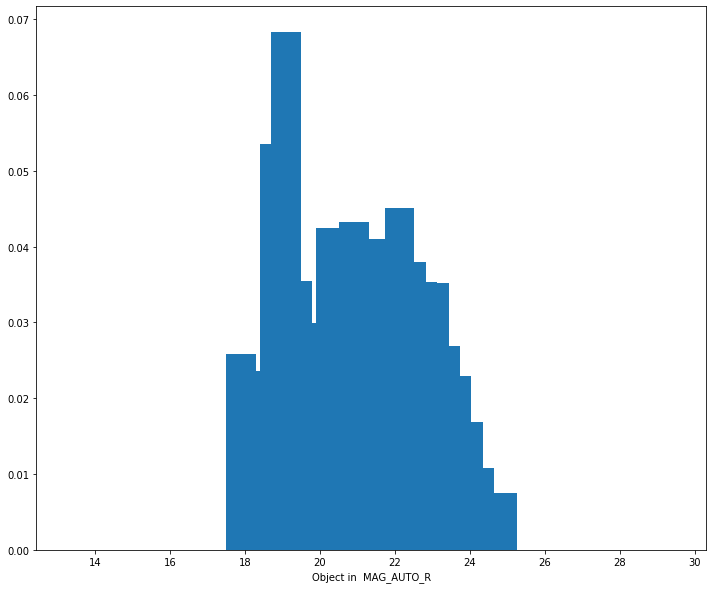

In [22]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

## Processing the data

We have some parts of our data that are **null**(not measured) values,

In [23]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_SPREAD_MODEL_G","WAVG_SPREAD_MODEL_R","WAVG_SPREAD_MODEL_I","WAVG_SPREAD_MODEL_Z","WAVG_SPREAD_MODEL_Y",
            "WAVG_FLUX_PSF_G","WAVG_FLUX_PSF_R","WAVG_FLUX_PSF_I","WAVG_FLUX_PSF_Z","WAVG_FLUX_PSF_Y",
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]


In [24]:
vvds[(vvds[feat[0]]==99) | (vvds[feat[0]]==-99)][feat[0]]

516     99.0
820     99.0
1020    99.0
1399    99.0
1484    99.0
1601    99.0
1840    99.0
2036    99.0
2756    99.0
3433    99.0
3601    99.0
4118    99.0
4635    99.0
4711    99.0
4748    99.0
4775    99.0
5331    99.0
Name: MAG_AUTO_G, dtype: float64

In [25]:
for j in feat:
    print(j,":",len(vvds[(vvds[j]==99) | (vvds[j]==-99)][j]),"\n")

MAG_AUTO_G : 17 

MAG_AUTO_R : 1 

MAG_AUTO_I : 1 

MAG_AUTO_Z : 4 

MAG_AUTO_Y : 263 

WAVG_SPREAD_MODEL_G : 1944 

WAVG_SPREAD_MODEL_R : 526 

WAVG_SPREAD_MODEL_I : 742 

WAVG_SPREAD_MODEL_Z : 1670 

WAVG_SPREAD_MODEL_Y : 4119 

WAVG_FLUX_PSF_G : 1944 

WAVG_FLUX_PSF_R : 526 

WAVG_FLUX_PSF_I : 742 

WAVG_FLUX_PSF_Z : 1670 

WAVG_FLUX_PSF_Y : 4119 

WAVG_MAG_PSF_G : 1944 

WAVG_MAG_PSF_R : 526 

WAVG_MAG_PSF_I : 742 

WAVG_MAG_PSF_Z : 1670 

WAVG_MAG_PSF_Y : 4119 



We have seen the null values of a data.

It is necessary to treat the data, to do so , first we want to maintain $95\%-97\%$ of our original data



In [26]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.31882970742685673 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  4.932483120780195 %
WAVG_SPREAD_MODEL_G  is  36.459114778694676 %
WAVG_SPREAD_MODEL_R  is  9.86496624156039 %
WAVG_SPREAD_MODEL_I  is  13.915978994748688 %
WAVG_SPREAD_MODEL_Z  is  31.32033008252063 %
WAVG_SPREAD_MODEL_Y  is  77.25056264066016 %
WAVG_FLUX_PSF_G  is  36.459114778694676 %
WAVG_FLUX_PSF_R  is  9.86496624156039 %
WAVG_FLUX_PSF_I  is  13.915978994748688 %
WAVG_FLUX_PSF_Z  is  31.32033008252063 %
WAVG_FLUX_PSF_Y  is  77.25056264066016 %
WAVG_MAG_PSF_G  is  36.459114778694676 %
WAVG_MAG_PSF_R  is  9.86496624156039 %
WAVG_MAG_PSF_I  is  13.915978994748688 %
WAVG_MAG_PSF_Z  is  31.32033008252063 %
WAVG_MAG_PSF_Y  is  77.25056264066016 %


Therefore, we have the percentage of null values in our dataset.

Here I make a choice for a our data, but first we make a further analysis.


In [27]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].mean()

20.48359148067968

In [28]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].median()

20.699167251586914

In [29]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].std()

0.672645486409636

In [30]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].min()

17.937219619750977

In [31]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].max()

21.42400550842285

Here we make one choice, change the values of $99$ for the median values of the WAVG_MAG_PSF_Y

In [32]:
vvds.loc[vvds[feat[15]]==99,feat[15]] = vvds[vvds[feat[15]]!=99][feat[15]].median()
vvds.loc[vvds[feat[16]]==99,feat[16]] = vvds[vvds[feat[16]]!=99][feat[16]].median()
vvds.loc[vvds[feat[17]]==99,feat[17]] = vvds[vvds[feat[17]]!=99][feat[17]].median()
vvds.loc[vvds[feat[18]]==99,feat[18]] = vvds[vvds[feat[18]]!=99][feat[18]].median()
vvds.loc[vvds[feat[19]]==99,feat[19]] = vvds[vvds[feat[19]]!=99][feat[19]].median()

In [33]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.31882970742685673 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  4.932483120780195 %
WAVG_SPREAD_MODEL_G  is  36.459114778694676 %
WAVG_SPREAD_MODEL_R  is  9.86496624156039 %
WAVG_SPREAD_MODEL_I  is  13.915978994748688 %
WAVG_SPREAD_MODEL_Z  is  31.32033008252063 %
WAVG_SPREAD_MODEL_Y  is  77.25056264066016 %
WAVG_FLUX_PSF_G  is  36.459114778694676 %
WAVG_FLUX_PSF_R  is  9.86496624156039 %
WAVG_FLUX_PSF_I  is  13.915978994748688 %
WAVG_FLUX_PSF_Z  is  31.32033008252063 %
WAVG_FLUX_PSF_Y  is  77.25056264066016 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [34]:
vvds.loc[vvds[feat[4]]==99,feat[4]] = vvds[vvds[feat[4]]!=99][feat[4]].median()
vvds.loc[vvds[feat[0]]==99,feat[0]] = vvds[vvds[feat[0]]!=99][feat[0]].median()
#vvds.loc[vvds[feat[3]]==99,feat[3]] = vvds[vvds[feat[3]]!=99][feat[3]].max()


In [35]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  36.459114778694676 %
WAVG_SPREAD_MODEL_R  is  9.86496624156039 %
WAVG_SPREAD_MODEL_I  is  13.915978994748688 %
WAVG_SPREAD_MODEL_Z  is  31.32033008252063 %
WAVG_SPREAD_MODEL_Y  is  77.25056264066016 %
WAVG_FLUX_PSF_G  is  36.459114778694676 %
WAVG_FLUX_PSF_R  is  9.86496624156039 %
WAVG_FLUX_PSF_I  is  13.915978994748688 %
WAVG_FLUX_PSF_Z  is  31.32033008252063 %
WAVG_FLUX_PSF_Y  is  77.25056264066016 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [36]:
for j in feat[1:4]:
    clean_tab(vvds,j,99)

In [37]:
print("With this choice we maintain",100*(len(vvds)/originalTam))

With this choice we maintain 99.90622655663915


In [38]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.0 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  36.399474375821285 %
WAVG_SPREAD_MODEL_R  is  9.799136474563545 %
WAVG_SPREAD_MODEL_I  is  13.85395156748639 %
WAVG_SPREAD_MODEL_Z  is  31.25586634128027 %
WAVG_SPREAD_MODEL_Y  is  77.22920968650273 %
WAVG_FLUX_PSF_G  is  36.399474375821285 %
WAVG_FLUX_PSF_R  is  9.799136474563545 %
WAVG_FLUX_PSF_I  is  13.85395156748639 %
WAVG_FLUX_PSF_Z  is  31.25586634128027 %
WAVG_FLUX_PSF_Y  is  77.22920968650273 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


## Plots

Some plot to understand, the best features to use

The features choose for our analysis is


* **WAVG_FLUX_PSF_G,R,I,Z,Y Weighted average flux measurement of PSF fit single epoch detections [ADU]**
* **MAG_AUTO_G,R,I,Z,Y Magnitude estimation, for an elliptical model based on the Kron radius [mag]**
* **WAVG_SPREAD_MODEL_G,R,I,Z,Y SPREAD MODEL using the weighted averaged values from single epoch detections**
* **WAVG_MAG_PSF_G,R,I,Z,Y Weighted average magnitude, of PSF fit single epoch detections [mag]**

**Plots for the completeza**

In [39]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vvds['MAG_AUTO_R'],bins = np.linspace(0,30,100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'Object in  MAG_AUTO_R')

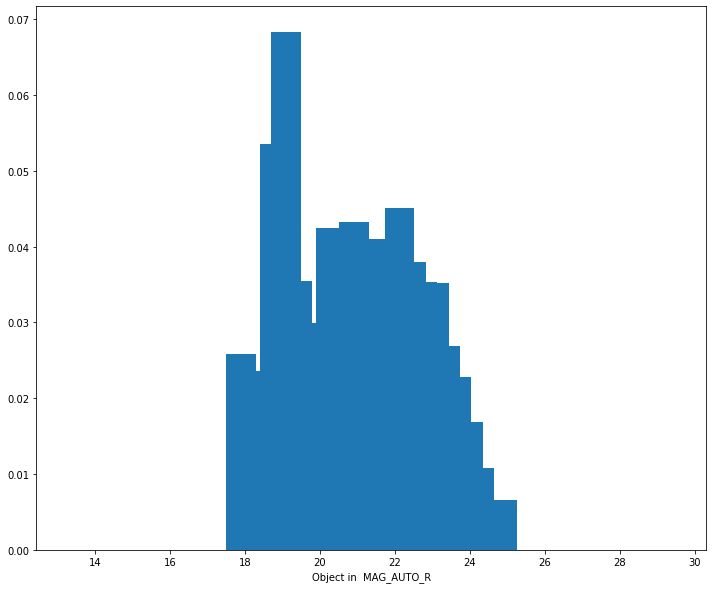

In [40]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

In [ ]:
feat.append("z")

<Figure size 2880x2304 with 0 Axes>

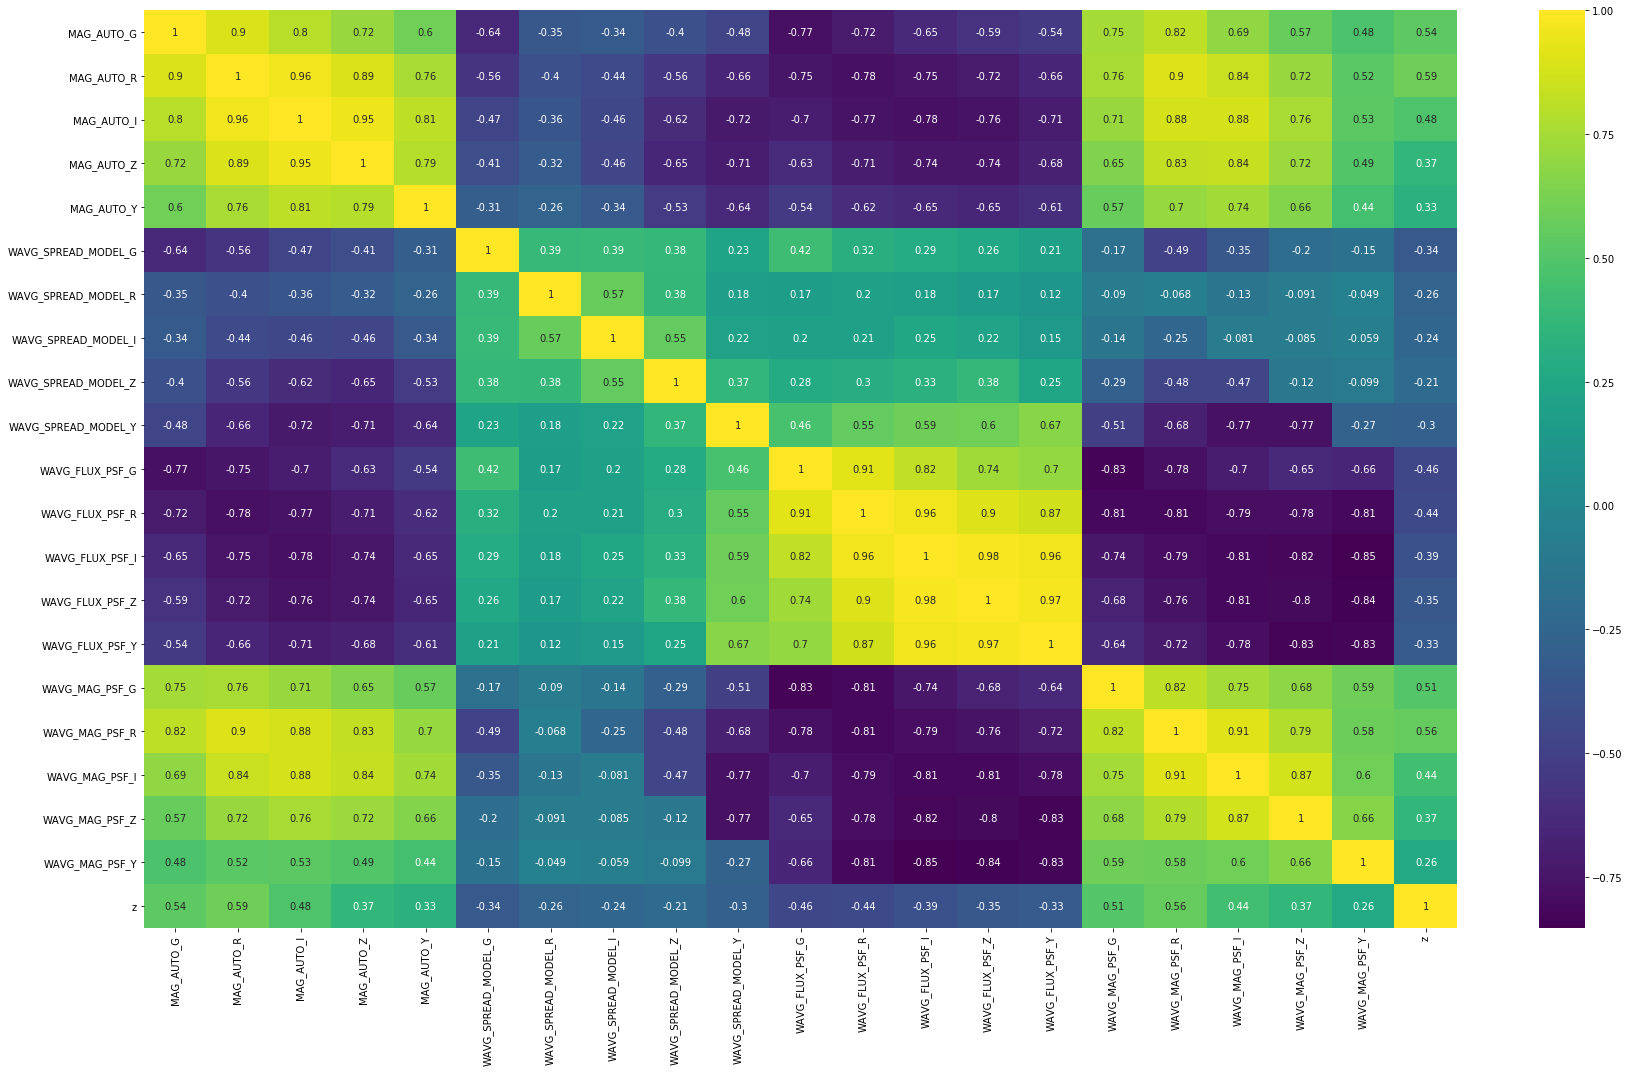

In [ ]:
plt.figure(figsize=(40,32))
corrmat = vvds[feat].corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

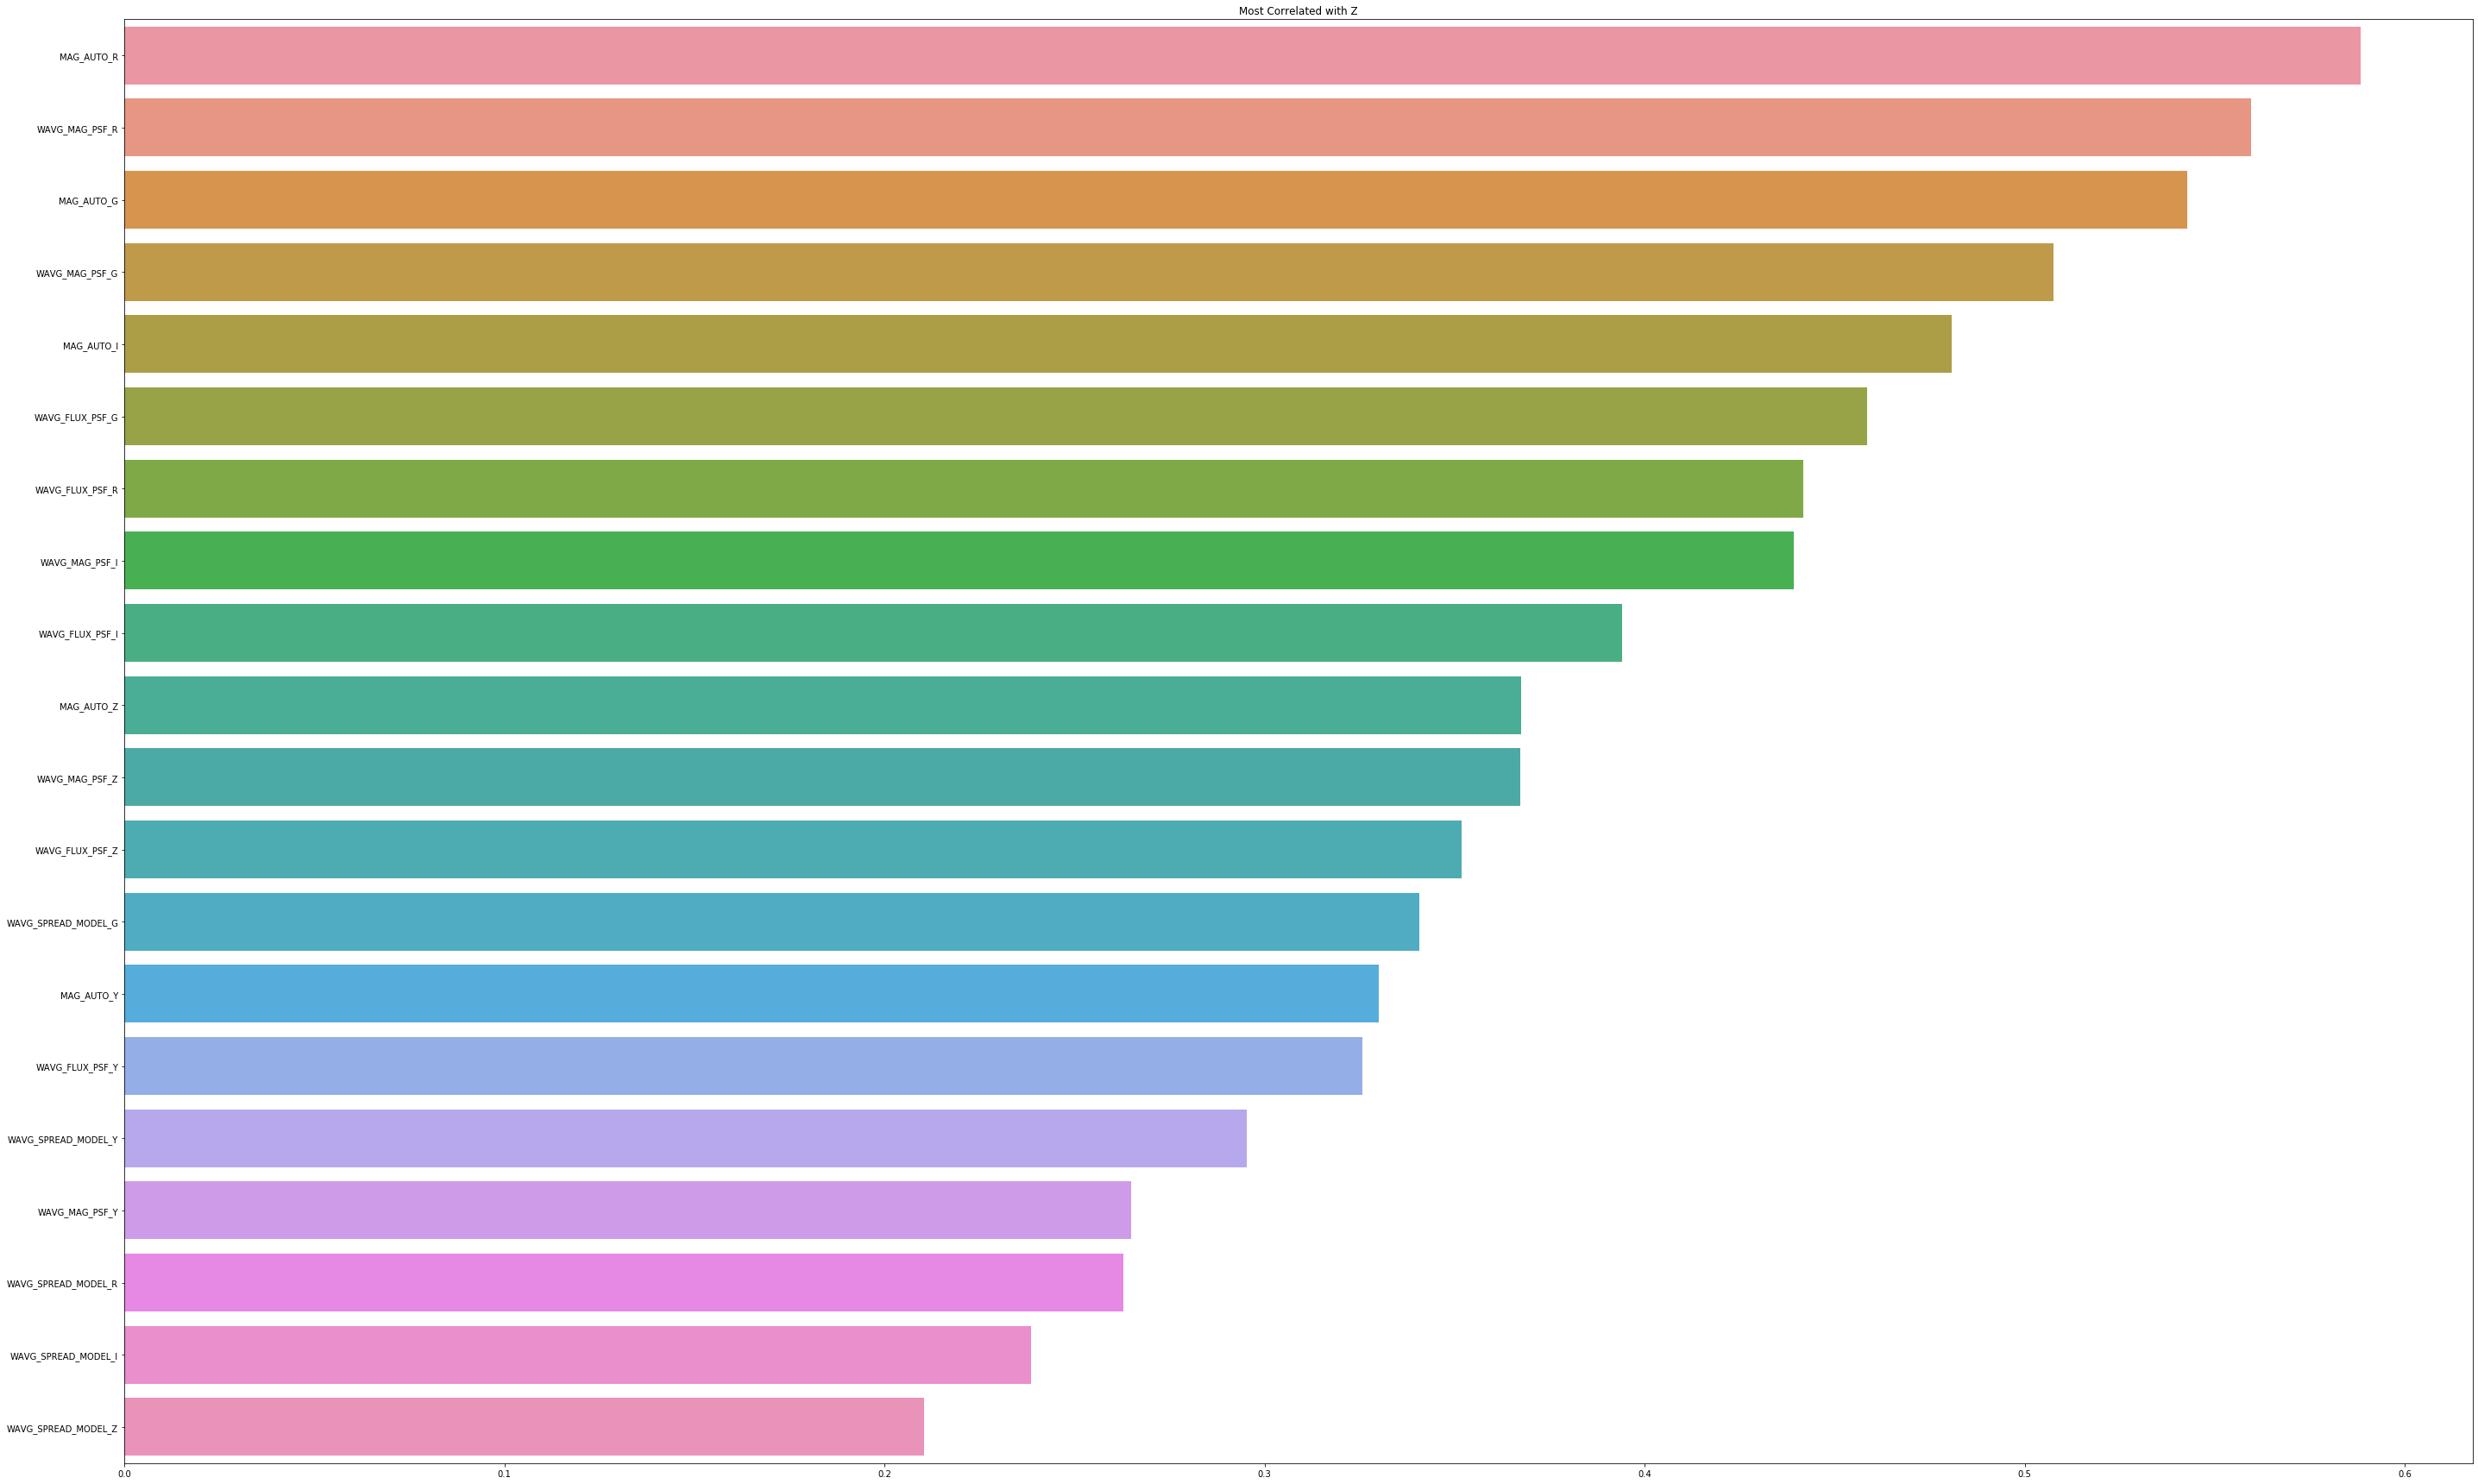

In [ ]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

<Figure size 1152x576 with 0 Axes>

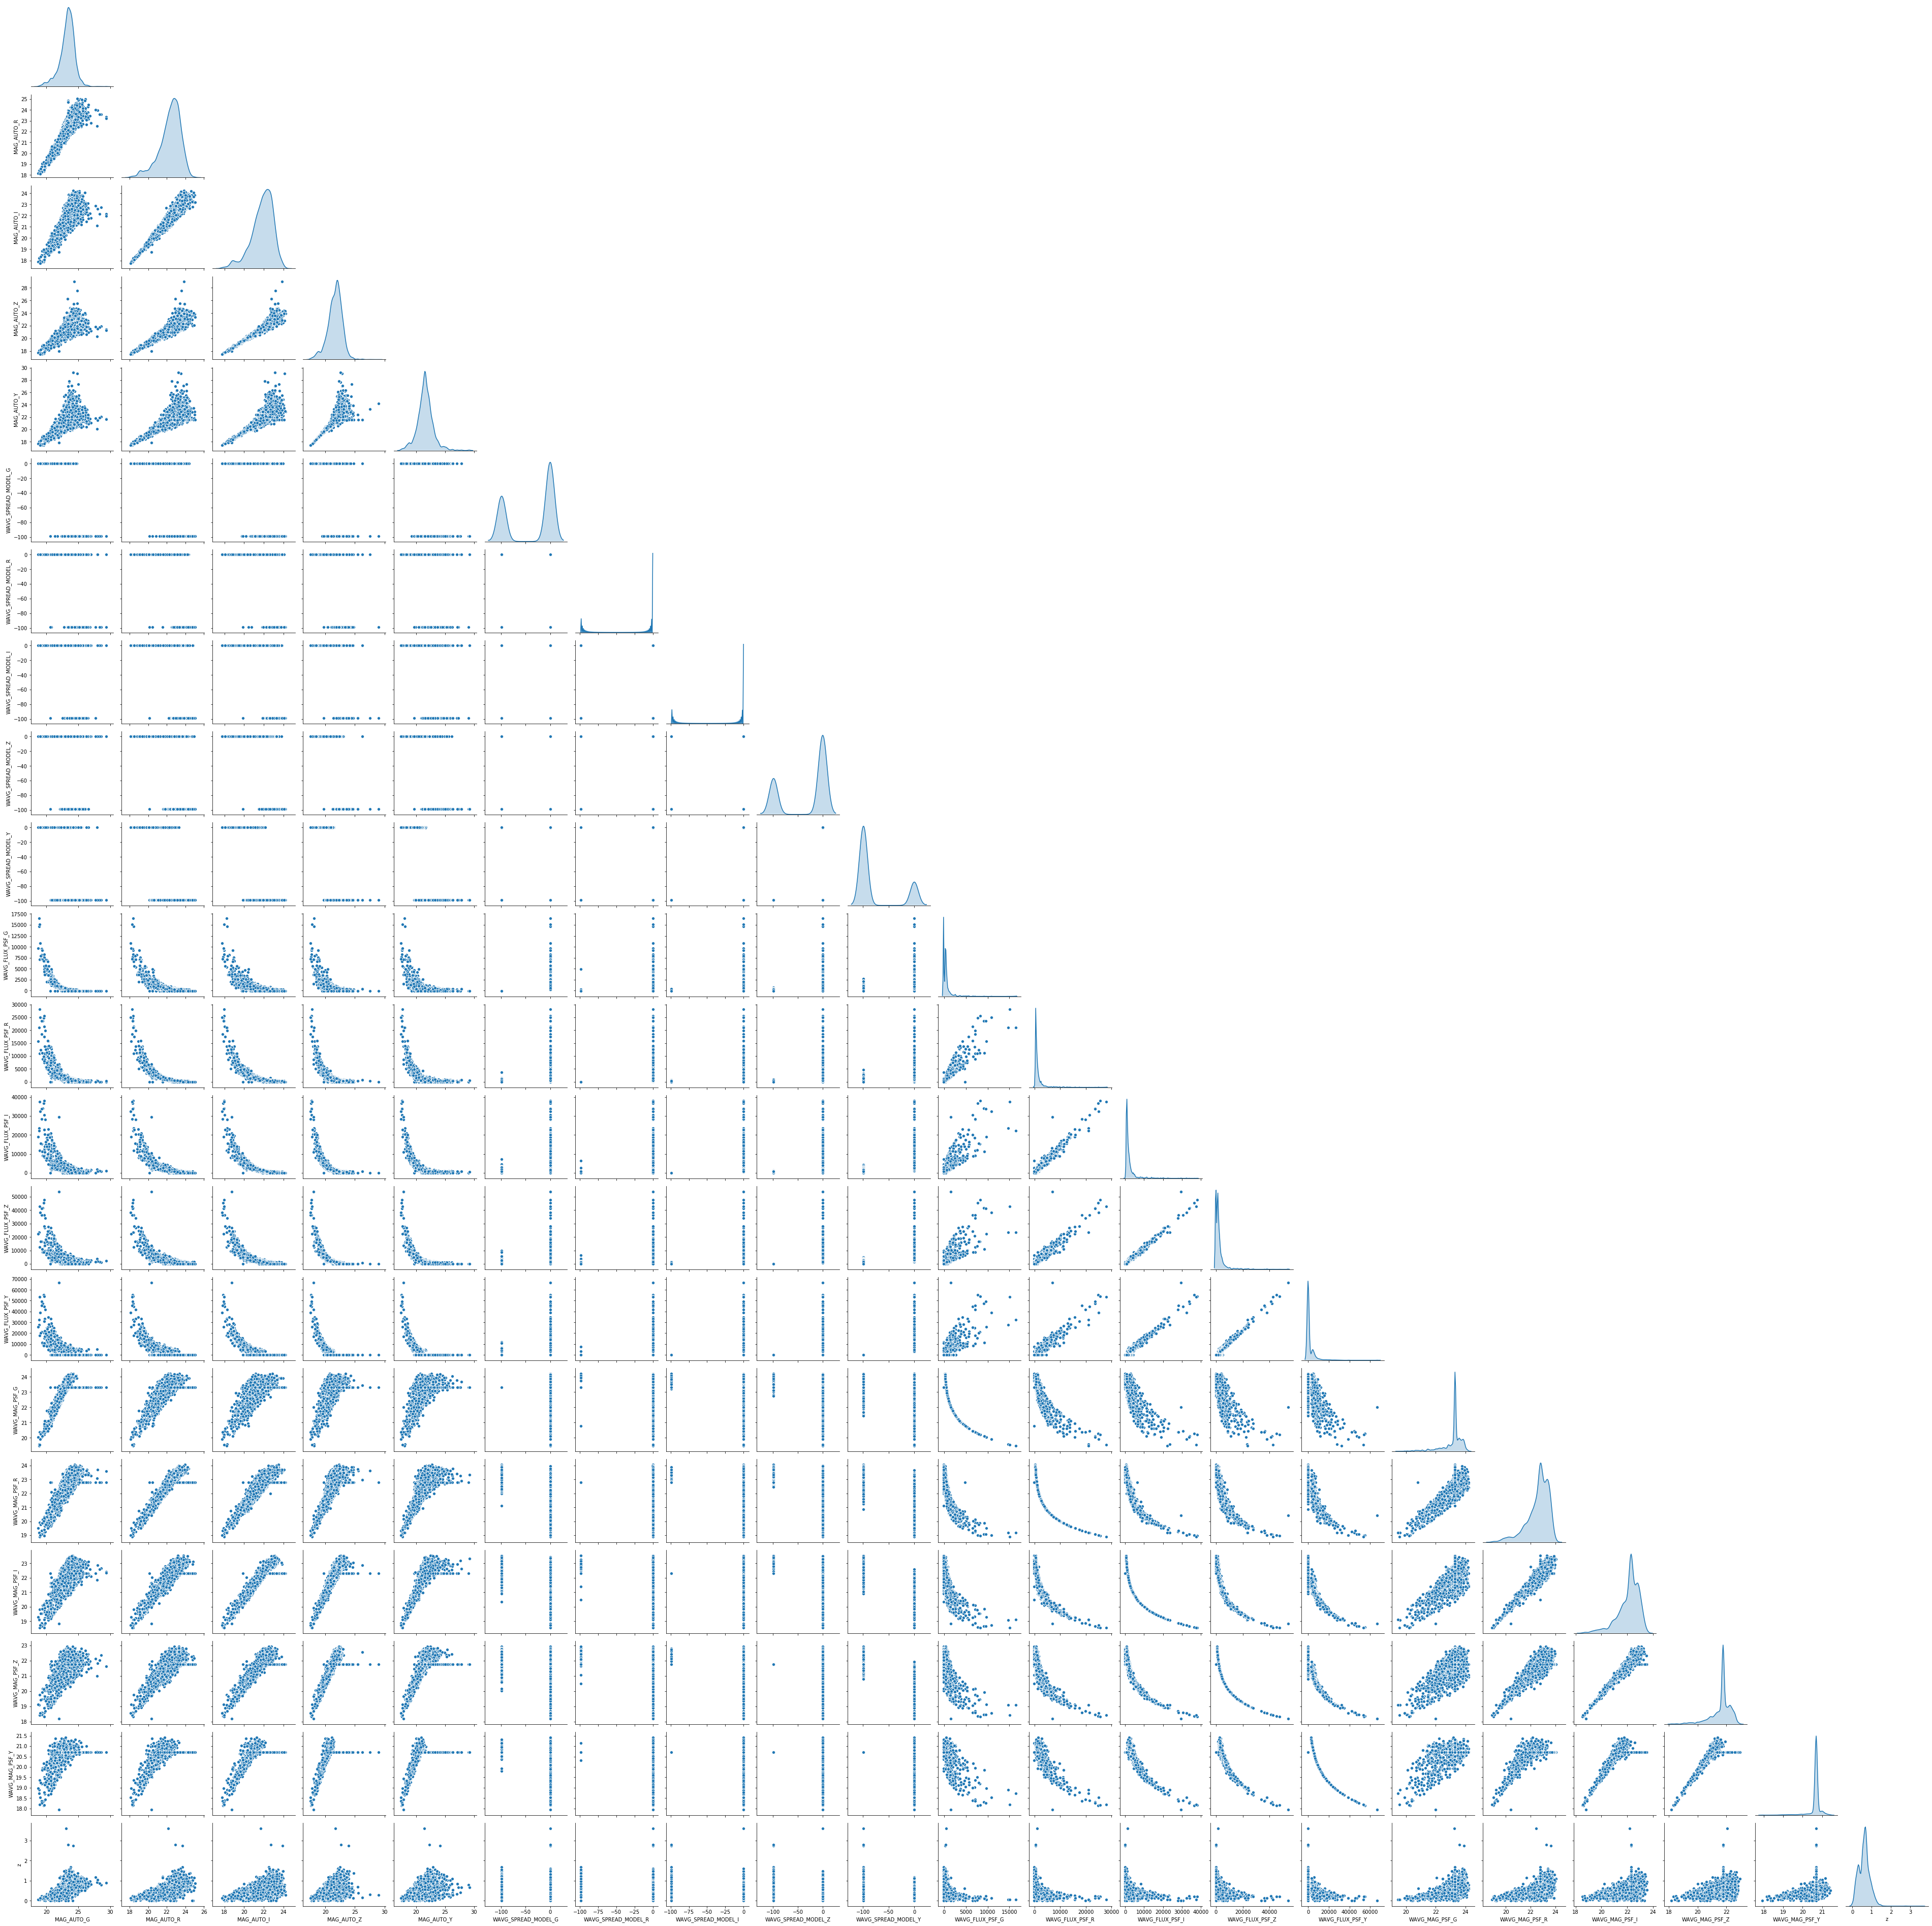

In [ ]:
plt.figure(figsize=(16,8))
sns.pairplot(vvds[feat],diag_kind= "kde",corner= True)

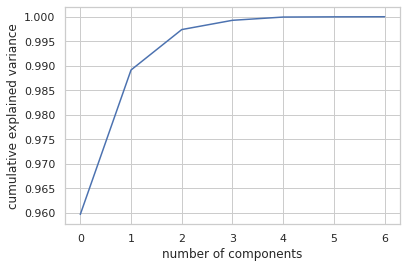

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.959701,0.959701
1,0.989128,0.029427
2,0.997367,0.008239
3,0.999256,0.001889
4,0.999918,0.000662
5,0.999961,0.000043
6,0.999981,0.000020


In [ ]:
pca_test = PCA(n_components=7)
pca_test.fit(vvds[feat[0:19]])
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=2, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=5)

In [ ]:
new_feat = pca.fit_transform(vvds[feat[0:19]])


In [ ]:
new_components = pd.DataFrame(new_feat,columns=["1 Component","2 Component","3 Component","4 Component","5 Component"])

In [ ]:
new_components["z"] = vvds["z"]

In [ ]:
new_components.head()

,1 Component,2 Component,3 Component,4 Component,5 Component,z
0,-2089.627950,-862.015537,-135.532831,159.217979,-122.331494,0.3939
1,2993.638473,-69.378842,868.858795,154.328029,-327.138160,0.4480
2,-3887.690469,789.725467,492.362920,50.402318,-98.540498,1.0345
3,-2410.286552,-443.177906,-137.898622,89.438897,-70.742298,0.3467
4,-1812.649972,-738.199551,-572.189835,151.758314,110.174133,0.7810


<Figure size 1152x864 with 0 Axes>

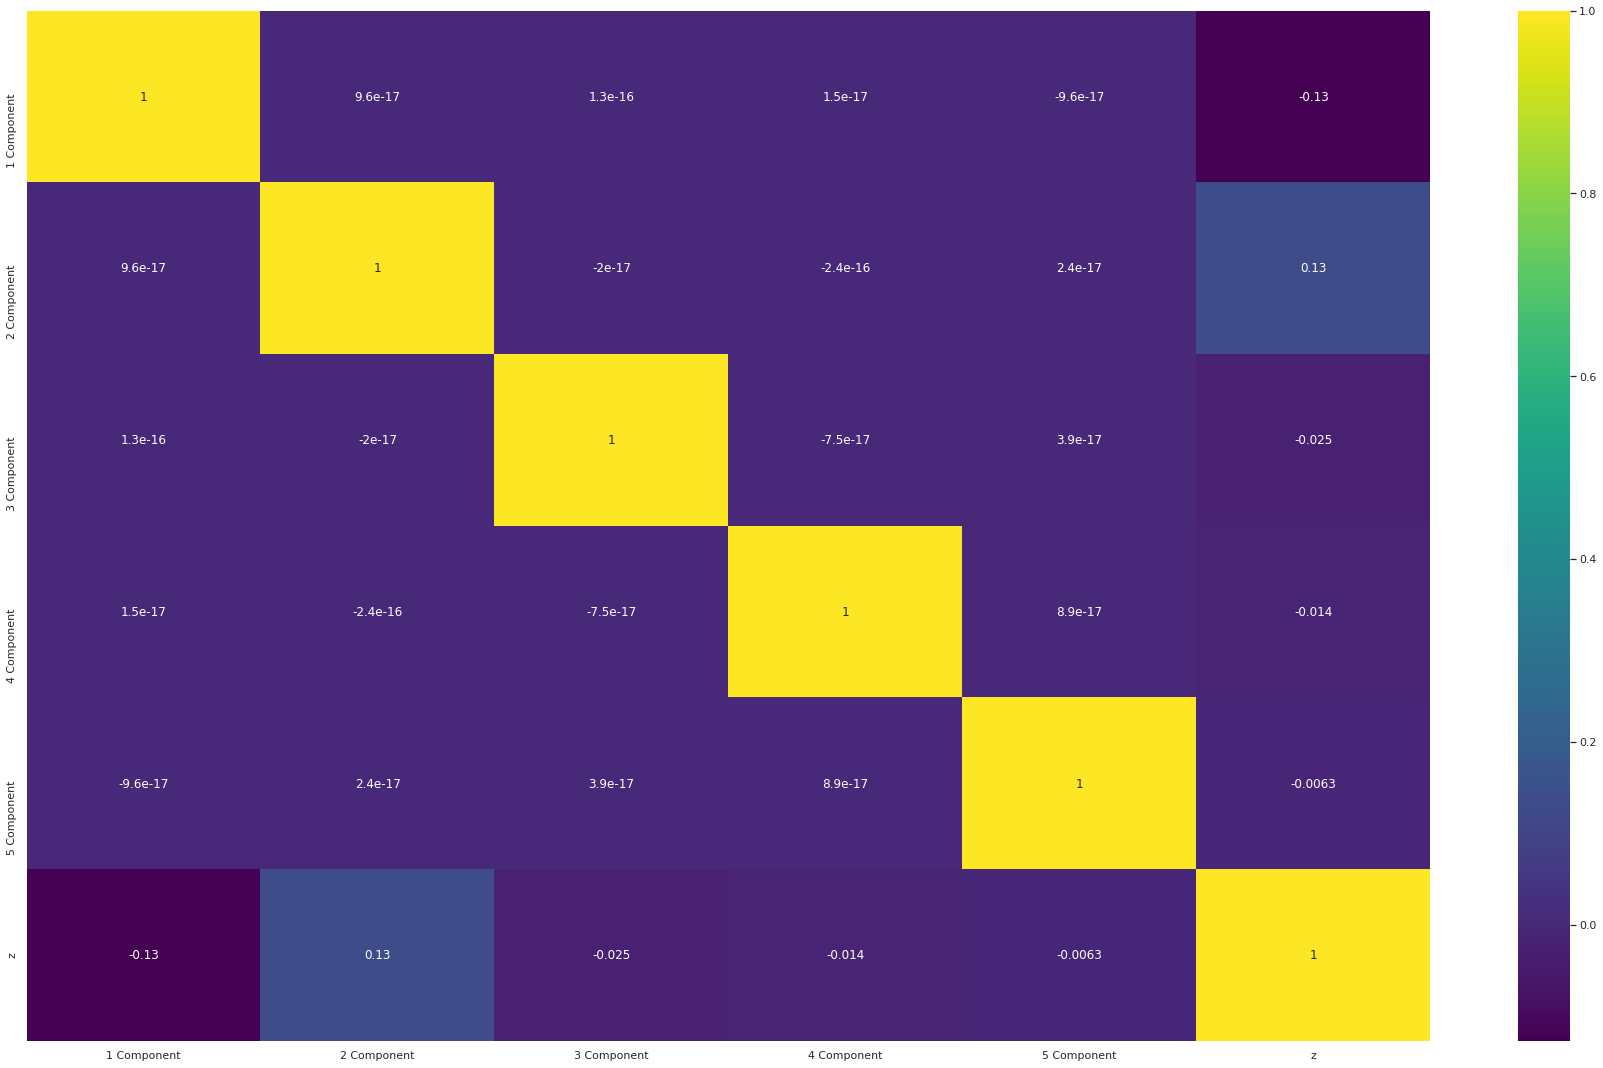

In [ ]:
plt.figure(figsize=(16,12))
corrmat1 = new_components.corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat1,annot=True,cmap="viridis")
plt.tight_layout()

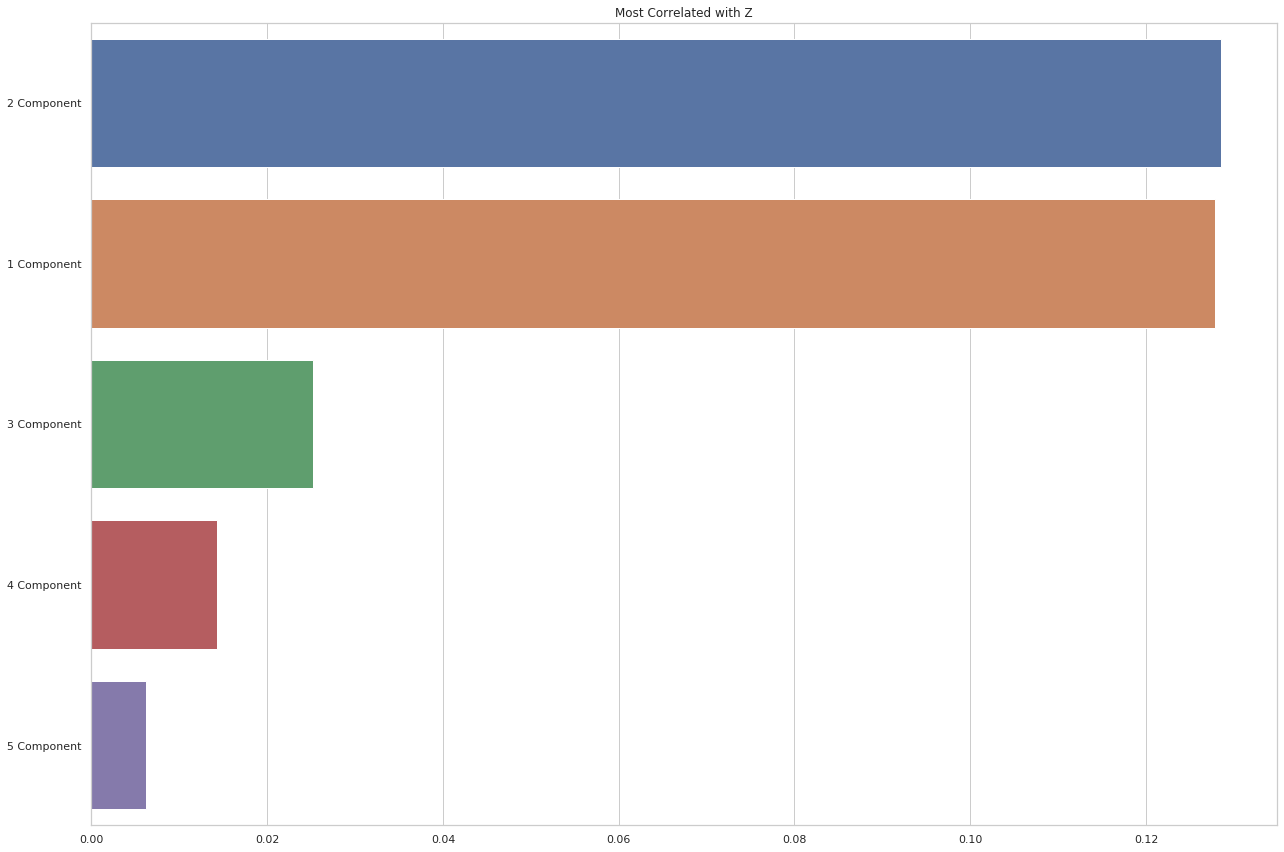

In [ ]:
plt.figure(figsize=(18,12))
correlations =corrmat1.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()

<Figure size 1152x576 with 0 Axes>

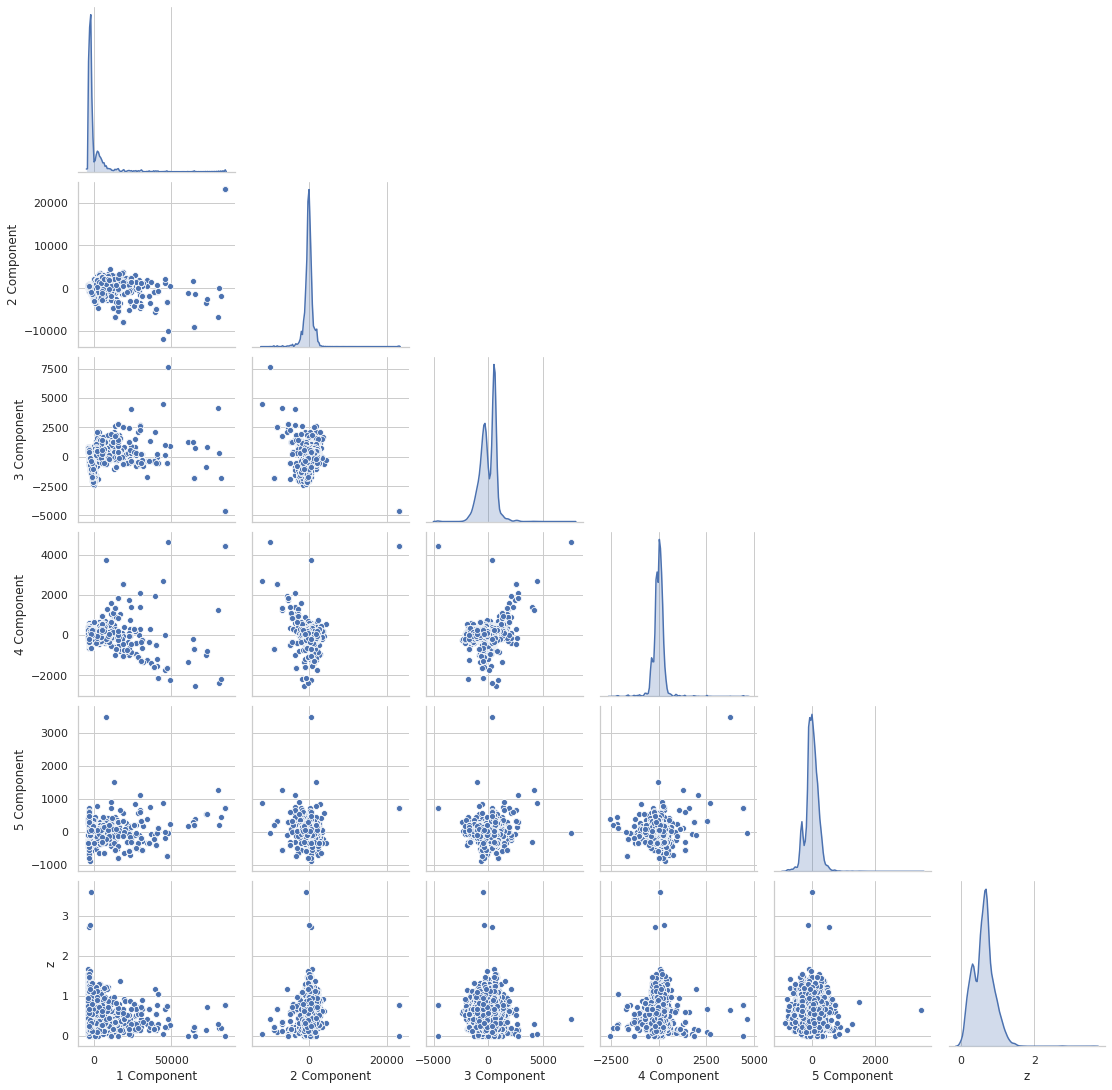

In [ ]:
plt.figure(figsize=(16,8))
sns.pairplot(new_components,diag_kind= "kde",corner= True)

## Machine Learning

In [ ]:
rob_scaler1 = RobustScaler()
rob_scaler2 = RobustScaler()

In [ ]:
features =['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]

X = vvds[features].values
y = vvds["z"].values

#X = rob_scaler1.fit_transform(X)
#y = rob_scaler2.fit_transform(y.reshape(-1,1))

In [ ]:
X_train, X_test,y_train, y_test = tts_split(X,y,0.3)

## Deep Learning methods

In [ ]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal'),
                       
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.35),

                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [ ]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [ ]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])


In [ ]:
history = ann_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[cp])


Epoch 1/1000
105/105 [==============================] - 0s 4ms/step - loss: 0.2527 - mse: 0.1078 - mae: 0.2521 - mape: 2499733.5000 - rmse_ann: 0.2521 - val_loss: 0.2098 - val_mse: 0.0714 - val_mae: 0.2091 - val_mape: 4589553.0000 - val_rmse_ann: 0.2091
Epoch 2/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.2282 - mse: 0.0873 - mae: 0.2276 - mape: 3037361.7500 - rmse_ann: 0.2276 - val_loss: 0.2175 - val_mse: 0.0755 - val_mae: 0.2169 - val_mape: 4339100.0000 - val_rmse_ann: 0.2169
Epoch 3/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.2219 - mse: 0.0826 - mae: 0.2213 - mape: 2742435.0000 - rmse_ann: 0.2213 - val_loss: 0.2189 - val_mse: 0.0764 - val_mae: 0.2183 - val_mape: 4316235.0000 - val_rmse_ann: 0.2183
Epoch 4/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.2183 - mse: 0.0795 - mae: 0.2177 - mape: 2827832.0000 - rmse_ann: 0.2177 - val_loss: 0.2445 - val_mse: 0.0910 - val_mae: 0.2439 - val_mape: 3785330.2500 - val_r

In [ ]:
plot_history(history)

In [ ]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann))

## Color space


We now reconstruct the redshift using the colour space

In [ ]:
def get_features_targets(data):
    features = np.zeros(shape=(len(data), 8))
    
    features[:, 0] = data['MAG_AUTO_G'] - data['MAG_AUTO_R']
    features[:, 1] = data['MAG_AUTO_R'] - data['MAG_AUTO_I']
    features[:, 2] = data['MAG_AUTO_I'] - data['MAG_AUTO_Z']
    features[:, 3] = data['MAG_AUTO_Z'] - data['MAG_AUTO_Y']
    features[:, 4] = data['WAVG_MAG_PSF_G'] - data['WAVG_MAG_PSF_R']
    features[:, 5] = data['WAVG_MAG_PSF_R'] - data['WAVG_MAG_PSF_I']
    features[:, 6] = data['WAVG_MAG_PSF_I'] - data['WAVG_MAG_PSF_Z']
    features[:, 7] = data['WAVG_MAG_PSF_Z'] - data['WAVG_MAG_PSF_Y']

    
    
    targets = data['z']
    return features, targets


In [ ]:
X,y = get_features_targets(vvds)


In [ ]:
X_train, X_test,y_train, y_test = tts_split(X,y.values,0.3)

In [ ]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [ ]:
ann_model.summary()

In [ ]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp_colour.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [ ]:
EarlyStop = EarlyStopping(monitor='rmse_ann', mode='min', patience=20)

In [ ]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])

In [ ]:
ann_model.fit(X_train,y_train,epochs=1000, batch_size=16, validation_split=0.1, callbacks=[cp, EarlyStop,PrintDot()])

In [ ]:
plot_history(history)

In [ ]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Mean Abs Error: {:5.2f} ".format(rmse_ann))

In [ ]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [ ]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * mae))

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}_colour.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_test, y_test))

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape, = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

In [ ]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()

In [ ]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [ ]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * mae))

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_test, y_test))

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape, = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = rmsle(y_test,test_predictions)
print("Testing set Root Mean Abs Error: ",error, " RMSE")

In [ ]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()